<a href="https://colab.research.google.com/github/midlajmarutha/deeplearning_pytorch/blob/master/03_computer_vision_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [74]:
import torch
from torch import nn

import torchvision
from torchvision import datasets
from torchvision import transforms
from torchvision.transforms import ToTensor

torch.__version__

'2.3.1+cu121'

In [75]:
!nvidia-smi

Fri Jul 26 14:24:19 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   48C    P0              30W /  70W |    171MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

### Generating data



In [76]:
train_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
    target_transform=None
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=torchvision.transforms.ToTensor(),
    target_transform=None
)

In [77]:
len(train_data), len(test_data)

(60000, 10000)

In [78]:
image, target = train_data[0]
image.shape

torch.Size([1, 28, 28])

In [79]:
classnames = train_data.classes
classnames

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

In [80]:
class_idx = train_data.class_to_idx
class_idx

{'T-shirt/top': 0,
 'Trouser': 1,
 'Pullover': 2,
 'Dress': 3,
 'Coat': 4,
 'Sandal': 5,
 'Shirt': 6,
 'Sneaker': 7,
 'Bag': 8,
 'Ankle boot': 9}

In [81]:
train_data.targets

tensor([9, 0, 0,  ..., 3, 0, 5])

In [82]:
import matplotlib.pyplot as plt

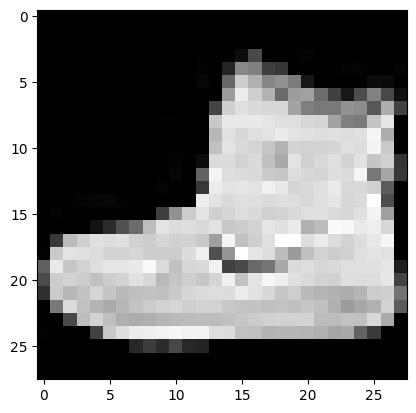

In [83]:
plt.imshow(image.squeeze(),cmap="gray")

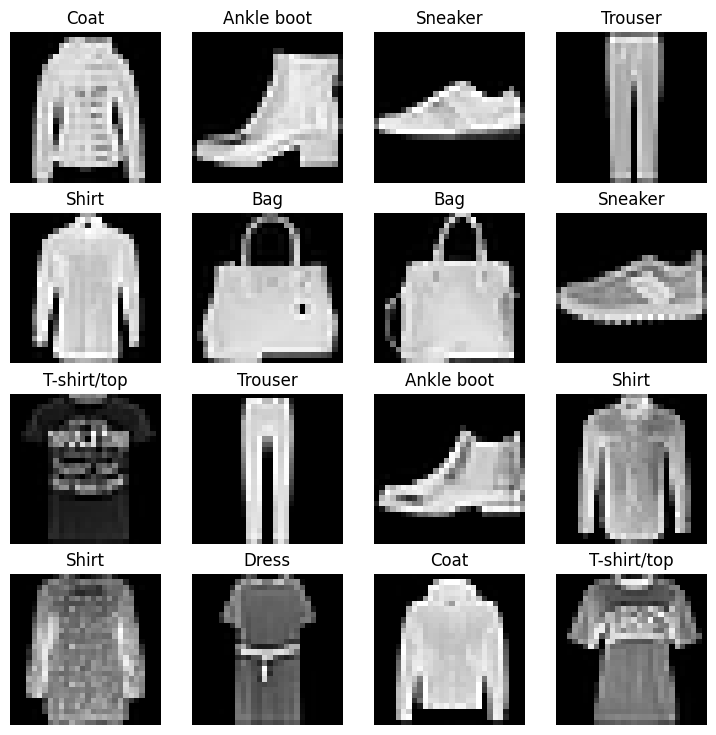

In [84]:
# torch.manual_seed(42)
fig = plt.figure(figsize=(9, 9))
row, col = 4,4
for i in range(1,row*col+1):
  im_index = torch.randint(0,len(train_data),size=[1]).item()
  im, la = train_data[im_index]
  fig.add_subplot(row, col, i)
  plt.imshow(im.squeeze(), cmap="gray")
  plt.title(classnames[la])
  plt.axis(False);

### Loading data using DataLoader

In [85]:
from torch.utils.data import DataLoader
BATCH_SIZE = 32

train_dataloader = DataLoader(dataset=train_data,
                              batch_size = BATCH_SIZE,
                              shuffle=True)

test_dataloader = DataLoader(dataset = test_data,
                             batch_size = BATCH_SIZE,
                             shuffle=False)
len(train_dataloader), len(test_dataloader)

(1875, 313)

In [86]:
train_features_batch, train_labels_batch = next(iter(train_dataloader))
train_features_batch.shape, train_labels_batch.shape

(torch.Size([32, 1, 28, 28]), torch.Size([32]))

In [87]:
flatten = nn.Flatten()
flatten(train_features_batch[1]).shape

torch.Size([1, 784])

### Building baseline model (model_0)

In [88]:
class FashionMNISTModel0(nn.Module):
  def __init__(self, input_size, output_size, hidden_units=10):
    super().__init__()
    self.layer_stack = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=input_size, out_features=hidden_units),
        nn.Linear(in_features=hidden_units, out_features=output_size)
    )

  def forward(self, x):
    return self.layer_stack(x)

model0 = FashionMNISTModel0(input_size=784,
                      output_size=len(train_data.classes)).to("cpu")
model0

FashionMNISTModel0(
  (layer_stack): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=10, bias=True)
    (2): Linear(in_features=10, out_features=10, bias=True)
  )
)

In [89]:
model0.state_dict()

OrderedDict([('layer_stack.1.weight',
              tensor([[ 0.0252,  0.0189, -0.0144,  ..., -0.0189, -0.0134,  0.0170],
                      [-0.0218,  0.0071, -0.0176,  ..., -0.0044,  0.0155, -0.0296],
                      [ 0.0081, -0.0277,  0.0282,  ...,  0.0244, -0.0247,  0.0274],
                      ...,
                      [ 0.0021, -0.0178,  0.0299,  ..., -0.0291, -0.0097, -0.0350],
                      [-0.0257, -0.0255, -0.0060,  ..., -0.0138,  0.0287, -0.0041],
                      [ 0.0346, -0.0357, -0.0206,  ..., -0.0045,  0.0198, -0.0073]])),
             ('layer_stack.1.bias',
              tensor([-0.0225,  0.0112,  0.0058,  0.0115, -0.0014,  0.0299, -0.0319, -0.0275,
                      -0.0297, -0.0099])),
             ('layer_stack.2.weight',
              tensor([[ 0.0790, -0.1147, -0.0804, -0.1549, -0.1240, -0.2832,  0.0223,  0.1004,
                       -0.1194,  0.0200],
                      [ 0.2671,  0.2040, -0.3044, -0.2488,  0.1332, -0.0133,  0.

In [90]:
# Setting loss function, optimizer and evaluation metrics
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model0.parameters(),
                            lr=0.01)

def accuracy_fn(y_true, y_pred):
  currect = torch.eq(y_true, y_pred).sum().item()
  accuracy = (currect / len(y_pred)) * 100
  return accuracy
def calaculate_time(start_time,
                    end_time,
                    device="cpu"):
  total_time = end_time - start_time
  print(f"{total_time:.2f}s on {device}")
  return total_time

### training and testing loop

In [91]:
from timeit import default_timer as timer
from tqdm.auto import tqdm
torch.manual_seed(42)
torch.cuda.manual_seed(42)
epochs = 3
train_start_cpu = timer()
for epoch in tqdm(range(epochs)):
  print(f"Epoch {epoch}")
  train_loss = 0
  for batch, (X,y) in enumerate(train_dataloader):
    # Training mode
    model0.train()

    # Forward pass
    logits = model0(X)
    y_pred = logits.argmax(dim=1)

    # calculate loss
    loss = loss_fn(logits, y)
    train_loss += loss

    # optimizer zero grad
    optimizer.zero_grad()

    # Backpropagation
    loss.backward()

    # updating  parameters
    optimizer.step()

    if batch % 400 == 0:
      print(f"Looked at {batch * len(X)}/{len(train_dataloader.dataset)}")

  train_loss /= len(train_dataloader)

  # Testing
  test_loss, test_acc = 0, 0
  model0.eval()
  with torch.inference_mode():
    for X, y in test_dataloader:

      # forward pass
      test_logits = model0(X)
      test_pred = test_logits.argmax(dim=1)

      # Loss and accuracy
      test_loss += loss_fn(test_logits, y)
      test_acc += accuracy_fn(y_true=y,
                         y_pred=test_pred)
    test_loss /= len(test_dataloader)
    test_acc /= len(test_dataloader)

  print(f"train_loss: {train_loss:.4f}, test_loss: {test_loss:.4f}, test_accuracy: {test_acc:.3f}%")
train_end_cpu = timer()
training_time_cpu = calaculate_time(train_start_cpu, train_end_cpu, device= str(next(model0.parameters()).device))

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 0
Looked at 0/60000
Looked at 12800/60000
Looked at 25600/60000
Looked at 38400/60000
Looked at 51200/60000
train_loss: 0.9141, test_loss: 0.6479, test_accuracy: 77.626%
Epoch 1
Looked at 0/60000
Looked at 12800/60000
Looked at 25600/60000
Looked at 38400/60000
Looked at 51200/60000
train_loss: 0.5712, test_loss: 0.5516, test_accuracy: 80.901%
Epoch 2
Looked at 0/60000
Looked at 12800/60000
Looked at 25600/60000
Looked at 38400/60000
Looked at 51200/60000
train_loss: 0.5078, test_loss: 0.5176, test_accuracy: 81.799%
41.73s on cpu


In [92]:
def evaluate_model(model:torch.nn.Module,
                   data_loader:torch.utils.data.DataLoader,
                   loss_fn: torch.nn.Module,
                   accuracy_fn):
  test_loss, test_acc = 0, 0
  model.eval()
  with torch.inference_mode():
    for X, y in tqdm(data_loader):
      test_logits = model(X)
      test_loss += loss_fn(test_logits, y)
      test_acc += accuracy_fn(y, test_logits.argmax(dim=1))
    test_loss /= len(data_loader)
    test_acc /= len(data_loader)

  return {"model": model.__class__.__name__,
          "test_loss": test_loss,
          "test_accuracy": test_acc}

In [93]:
model0_result = evaluate_model(model=model0,
                              data_loader=test_dataloader,
                              loss_fn= loss_fn,
                              accuracy_fn=accuracy_fn)
model0_result

  0%|          | 0/313 [00:00<?, ?it/s]

{'model': 'FashionMNISTModel0',
 'test_loss': tensor(0.5176),
 'test_accuracy': 81.7991214057508}

In [94]:
from pathlib import Path

MODEL_DIR = Path("model")
MODEL_DIR.mkdir(parents=True,
                exist_ok=True)
MODEL_NAME = "FashionMNISTClassificationV0.pth"
MODEL_PATH = MODEL_DIR / MODEL_NAME
torch.save(obj = model0.state_dict(),f=MODEL_PATH)

### Model1: Improving model with non-linearity

In [111]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [96]:
class FashionMNISTModelV1(nn.Module):
  def __init__(self, input_size, output_size, hidden_units=10):
    super().__init__()
    self.layer_stack = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=input_size, out_features=hidden_units),
        nn.ReLU(),
        nn.Linear(in_features=hidden_units, out_features=output_size),
        nn.ReLU()
    )
  def forward(self, x):
    return self.layer_stack(x)

model1 = FashionMNISTModelV1(input_size=784,
                             output_size=len(train_data.classes),
                             ).to(device)

In [97]:
model1

FashionMNISTModelV1(
  (layer_stack): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=10, bias=True)
    (2): ReLU()
    (3): Linear(in_features=10, out_features=10, bias=True)
    (4): ReLU()
  )
)

### Setting up loss function, optimizer, evaluation metrics(accuracy)

In [98]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model1.parameters(),
                            lr=0.01)

#### functionising training and evaluating/testing process

In [99]:
def train_model(model: torch.nn.Module,
                data_loader: torch.utils.data.DataLoader,
                loss_fn: torch.nn.Module,
                optimizer: torch.optim.Optimizer,
                accuracy_fn,
                device: torch.device = device):
  train_loss, train_acc = 0, 0
  for batch, (X, y) in enumerate(data_loader):
    model.train()
    X, y = X.to(device), y.to(device)
    # forward pass
    train_logits = model(X)
    train_pred = train_logits.argmax(dim=1)

    # calculating loss
    loss = loss_fn(train_logits, y)
    train_loss += loss
    train_acc += accuracy_fn(y_true=y, y_pred=train_pred)

    # clearing gradients
    optimizer.zero_grad()

    # Backpropagation
    loss.backward()

    # updating gradients
    optimizer.step()

    if batch % 400 == 0:
      print(f"Looked at {batch * len(X)}/{len(data_loader.dataset)}")

  train_loss /= len(data_loader)
  train_acc /= len(data_loader)
  return train_loss, train_acc

In [100]:
def test_model(model:torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               accuracy_fn,
               device: torch.device = device):
  test_loss, test_acc = 0, 0
  model.eval()
  with torch.inference_mode():
    for X, y in data_loader:
      X, y = X.to(device), y.to(device)
      # Forward pass
      test_logits = model(X)

      # Calculating loss
      test_loss += loss_fn(test_logits, y)
      test_acc += accuracy_fn(y_true=y, y_pred=test_logits.argmax(dim=1))

    test_loss /= len(data_loader)
    test_acc /= len(data_loader)
  return test_loss, test_acc

In [101]:
# Training improved model

epochs = 3
for epoch in tqdm(range(epochs)):
  print(f"epoch: {epoch}---------------")
  train_loss, train_acc = train_model(model=model1,
                                      data_loader = train_dataloader,
                                      loss_fn = loss_fn,
                                      optimizer = optimizer,
                                      accuracy_fn=accuracy_fn)
  test_loss, test_acc = test_model(model=model1,
                                   data_loader=test_dataloader,
                                   loss_fn=loss_fn,
                                   accuracy_fn=accuracy_fn)
  print(f"train_loss: {train_loss:.4f}, train_acc:{train_acc:.2f}%, test_loss: {test_loss:.4f}, test_acc: {test_acc:.2f}%")

  0%|          | 0/3 [00:00<?, ?it/s]

epoch: 0---------------
Looked at 0/60000
Looked at 12800/60000
Looked at 25600/60000
Looked at 38400/60000
Looked at 51200/60000
train_loss: 1.6430, train_acc:45.79%, test_loss: 1.3042, test_acc: 60.76%
epoch: 1---------------
Looked at 0/60000
Looked at 12800/60000
Looked at 25600/60000
Looked at 38400/60000
Looked at 51200/60000
train_loss: 1.1151, train_acc:64.51%, test_loss: 1.0434, test_acc: 65.17%
epoch: 2---------------
Looked at 0/60000
Looked at 12800/60000
Looked at 25600/60000
Looked at 38400/60000
Looked at 51200/60000
train_loss: 0.9876, train_acc:66.89%, test_loss: 0.9922, test_acc: 66.60%


Looks like our model is weaker than the without non-linearity model

### Model 2: Building Neural network with Convolutional layer

In [132]:
class FashionMNISTModelV2(nn.Module):
  def __init__(self, input_shape, output_shape, hidden_units):
    super().__init__()
    self.conv_block1 = nn.Sequential(
          nn.Conv2d(in_channels=input_shape,
                    out_channels=hidden_units,
                    kernel_size=3,
                    stride=1,
                    padding=1),
          nn.ReLU(),
          nn.Conv2d(in_channels=hidden_units,
                    out_channels=hidden_units,
                    kernel_size=3,
                    stride=1,
                    padding=1),
          nn.ReLU(),
          nn.MaxPool2d(kernel_size=2)
        )
    self.conv_block2 = nn.Sequential(
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2)
      )
    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=490, # 10*7*7 (flattened output from 2nd maxpool layer)
                  out_features=output_shape)
    )
  def forward(self, x):
    x = self.conv_block1(x)
    x = self.conv_block2(x)
    x = self.classifier(x)
    return x

In [133]:
model2 = FashionMNISTModelV2(input_shape=1,
                             output_shape=len(classnames),
                             hidden_units=10).to(device)

In [134]:
# training
epochs = 3
train_start_time = timer()
for epoch in tqdm(range(epochs)):
  train_loss, test_acc = train_model(model=model2,
                                    data_loader=train_dataloader,
                                    loss_fn=loss_fn,
                                    optimizer=optimizer,
                                    accuracy_fn=accuracy_fn)
  test_loss, test_acc = test_model(model=model2,
                                   data_loader=test_dataloader,
                                   loss_fn=loss_fn,
                                   accuracy_fn=accuracy_fn)
  print(f"train_loss: {train_loss:.4f}, train_acc: {train_acc:.2f}%, test_loss: {test_loss:.4f}, test_acc: {test_acc:.2f}%")
total_time = timer() - train_start_time
print(f"took {total_time}s to train the model")

  0%|          | 0/3 [00:00<?, ?it/s]

Looked at 0/60000
Looked at 12800/60000
Looked at 25600/60000
Looked at 38400/60000
Looked at 51200/60000
train_loss: 2.3031, train_acc: 66.89%, test_loss: 2.3031, test_acc: 9.99%
Looked at 0/60000
Looked at 12800/60000
Looked at 25600/60000
Looked at 38400/60000
Looked at 51200/60000
train_loss: 2.3031, train_acc: 66.89%, test_loss: 2.3031, test_acc: 9.99%
Looked at 0/60000
Looked at 12800/60000
Looked at 25600/60000
Looked at 38400/60000
Looked at 51200/60000
train_loss: 2.3031, train_acc: 66.89%, test_loss: 2.3031, test_acc: 9.99%
took 37.198658973999954s to train the model
